In [1]:
from pydrake.common.containers import namedview 

from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix

import numpy as np

from underactuated.meshcat_utils import AddMeshcatTriad

import Simulation as sim    


import GeometryUtils as geoUtils 
from pydrake.geometry import Rgba

import pickle

from pydrake.all import Simulator

    
import pydrake.symbolic as sym

from FixedWing import FullState

from pydrake.all import StartMeshcat
import FixedWing as fw


from matplotlib import pyplot as plt

from pydrake.all import PiecewisePolynomial

from pydrake.all import MeshcatAnimation

from pydrake.all import Meshcat

from manipulation.scenarios import AddRgbdSensors


In [2]:


# from pydrake.all import (
#     RotationMatrix
# )

# Implemented in accordance with notation from https://thesis.unipd.it/retrieve/a2c7ed88-c8a9-47ad-8a4c-798b2a4c345e/Pasquali_Monika.pdf

FixedWingStatesNED = namedview(
    "FixedWingNStatesNED", ["x", "y", "z", "v_a", "betha", "alpha", "chi", "gamma", "mu", "p", "q", "r"]
)

# Center of gravity of the aircraft
CoG = namedview(
    "CoG", ["x", "y", "z"]
)


def ConvertToNEDcoordinate(p_Dr,dp_Dr,ddp_Dr,dddp_Dr):
    
    X_IDr = RigidTransform(RotationMatrix.MakeXRotation(-np.pi))
    
    p_ned = X_IDr @ p_Dr
    dp_ned = X_IDr @ dp_Dr
    ddp_ned = X_IDr @ ddp_Dr
    dddp_ned = X_IDr @ dddp_Dr
    
    return p_ned, dp_ned, ddp_ned, dddp_ned
    

ind = 0 
 
def UnflattenFixedWingStatesNED(p_Dr,dp_Dr,ddp_Dr,dddp_Dr, m, g):
    
    '''
    input: x: np.array of shape (3,)
    '''
    global ind
    p, dp, ddp, dddp = ConvertToNEDcoordinate(p_Dr,dp_Dr,ddp_Dr,dddp_Dr)
    
    
    
    # geoUtils.visualize_point(meshcat, p, label=f"test/p_{ind}", radius=0.01, color=Rgba(.06, 0, 0, 1)) 
    ind +=1
    
    s = FixedWingStatesNED(np.zeros(12))
    
    p_n = CoG(p)
    dp_n = CoG(dp)
    ddp_n = CoG(ddp)
    dddp_n = CoG(dddp)
    
    
    
    s[0:3] = p  # x, y, z
    
    s.v_a = np.sqrt( dp.T @ dp) 
    
    s.betha = 0  #np.arctan2(-dp_n.y, dp_n.x) #np.pi/6 # assumed 0 for fixed wing
    
    s.alpha = 0 # np.arctan2(dp_n.z , dp_n.x) # assumed 0 for now  # np.arctan2(dx[2], dx[0])
    
    s.gamma = np.arcsin(- dp_n.z/s.v_a)
    
    # Works better with atan2(ddp_n.y, ddp_n.x) hmm
    s.chi = np.arctan2(dp_n.y, dp_n.x)
    
    
    
    dx_ddx = dp_n.x * ddp_n.x
    dy_ddy = dp_n.y * ddp_n.y
    dz_ddz = dp_n.z * ddp_n.z
    sum_dt_p = dx_ddx + dy_ddy + dz_ddz
    
    
    dv_a = sum_dt_p / s.v_a # PAPER says s.v_a**2, but I think it should be s.v_a
    
    
    d_dx_ddx = ddp_n.x**2 + dp_n.x*dddp_n.x
    d_dy_ddy = ddp_n.y**2 + dp_n.y*dddp_n.y
    d_dz_ddz = ddp_n.z**2 + dp_n.z*dddp_n.z
    
    sum_ddt_p = d_dx_ddx + d_dy_ddy + d_dz_ddz
    
    ddv_a = (sum_ddt_p*s.v_a - sum_dt_p * dv_a ) / s.v_a**2  # PAPER says something else, but I think it might be a propagation error from dv_a
    
    sqrt_exp = np.sqrt(1 - (dp_n.z/s.v_a)**2) 
    dgamma = - ddp_n.z/(s.v_a * sqrt_exp) + dp_n.z*dv_a / (s.v_a**2 * sqrt_exp) # SAME AS PAPER
    
    f = dp_n.x * ddp_n.y - dp_n.y * ddp_n.x
    g = dp_n.x**2 + dp_n.y**2
    dchi = f / g # SAME AS PAPER
    
    df = dddp_n.y*dp_n.x - dddp_n.x*dp_n.y 
    dg = 2*dp_n.x*ddp_n.x + 2*dp_n.y*ddp_n.y
    ddchi = (df*g - f*dg ) / g**2 # SAME AS PAPER
    
    
    t = s.v_a * m * np.cos(s.gamma) * dchi
    b = s.v_a * m * dgamma + np.cos(s.gamma)*g*m
    s.mu = np.arctan2(t, b) # FROM PAPER
    
    # print(f"z_dot: {dp_n.z}")
    # print(f"s.v_a: {s.v_a}, sqrt_exp: {sqrt_exp}, s.b : {b}")
    
            
    
    return s[:]



def ExtractTransformationNED(statesNED):
    
    s = FixedWingStatesNED(statesNED)
    
    # TODO : iplement rotation by hand
    
    # print out the euler angles 
    # print(f"chi: {s.chi}, gamma: {s.gamma}, mu: {s.mu}")
    
    R_OA = RollPitchYaw(s.mu, s.gamma, s.chi).ToRotationMatrix()
    
    R_BA = RotationMatrix.MakeYRotation(-s.alpha) @ RotationMatrix.MakeZRotation(s.betha)
    
    R_OB = R_OA @ R_BA.transpose()  
    
    # print(f"s.chi: {s.chi}, s.gamma: {s.gamma}, s.mu: {s.mu}")
    # print("R_OB: ", R_OB)
    
    # R_OB_temp = R_OB @ RotationMatrix.MakeXRotation(np.pi/2)
    # R_OB = R_IB
    X_IB = RigidTransform(R_OB, s[0:3])
    
    return X_IB 
    

def ExtractTransformation(statesNED):
    
    X_IB = ExtractTransformationNED(statesNED)
    
    
    X_DrI = RigidTransform(RotationMatrix.MakeXRotation(np.pi))
    
    X_DrB = X_DrI @ X_IB
    
    return X_DrB


# Flat output inverter

In [3]:
# m = 1.56
# g = 9.81

# # meshcat.Delete("traj_source/")
# # meshcat.Delete("test/")


# start_time = 0
# end_time = 20



# num_timesteps = 1000
# num_dofs = 3
# p_numeric = np.empty((num_timesteps, num_dofs))
# dp_numeric = np.empty((num_timesteps, num_dofs))
# ddp_numeric = np.empty((num_timesteps, num_dofs))
# dddp_numeric = np.empty((num_timesteps, num_dofs))


# sample_times_s = np.linspace(
#     start_time, end_time, num=num_timesteps, endpoint=True
# )

# for i, t in enumerate(sample_times_s):
#     if traj == 0:
#         p_numeric[i] = trajectory.value(t).flatten()
#         dp_numeric[i] = trajectory.EvalDerivative(t, derivative_order=1).flatten()
#         ddp_numeric[i] = trajectory.EvalDerivative(t, derivative_order=2).flatten()
#         dddp_numeric[i] = trajectory.EvalDerivative(t, derivative_order=3).flatten()
#     elif traj == 1:
#         ( p_numeric[i],
#          dp_numeric[i], 
#          ddp_numeric[i], 
#          dddp_numeric[i] ) = get_pathAndDerivativs(t)
    

# trajectory_frames = []

# for p, dp, ddp, dddp, t in zip(
#     p_numeric,
#     dp_numeric,
#     ddp_numeric,
#     dddp_numeric,
#     sample_times_s
# ):

#     stateNED = UnflattenFixedWingStatesNED(p, dp, ddp, dddp, m, g)
    
#     X_DrB = ExtractTransformation(stateNED[:])
    
#     trajectory_frames.append(X_DrB)

# # simulator.meshcat.Delete("test/")
# visualize_key_frames(trajectory_frames)

### Own defined paths

In [4]:

t_arr = np.array([sym.Variable("t")])

def f_straigth_x(t_arr):
    m = sym if t_arr.dtype == object else np
    
    return np.array(
        [ t_arr[0],
         0,
         1
        ]
    )

def f_straight_xy(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ t_arr[0],
          -t_arr[0],
          1
        ]
    )

def f_straight_xz(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ t_arr[0],
          0,
          t_arr[0]*.1
        ]
    )

def f_sine_xz(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ t_arr[0],
          0,
          1.2 + m.sin(t_arr[0])
        ]
    )
    
def f_sine_xy(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ t_arr[0],
          m.sin(t_arr[0])*0.5,
          1 + m.sin(t_arr[0])*0.4,
        ]
    )
    
def f_sine_xyz(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ t_arr[0],
          t_arr[0],
          1.2 + m.sin(t_arr[0])
        ]
    )


def f_circle(t_arr):
    m = sym if t_arr.dtype == object else np
    return np.array(
        [ m.cos(t_arr[0]),
          m.sin(t_arr[0]),
          1
        ]
    )

def f_infinity(t_arr):
    m = sym if t_arr.dtype == object else np
    return 2*np.array(
        [ m.cos(t_arr[0]) / (1 + m.sin(t)**2),
         m.cos(t_arr[0]) * m.sin(t_arr[0]) / (1 + m.sin(t_arr[0])**2),
         1 
        ]
    )


i = 3

f = None
if i==0:
    f = f_straigth_x
elif i==1:
    f = f_straight_xy
elif i==2:
    f = f_straight_xz
elif i==3:
    f = f_sine_xy
elif i==4:
    f = f_sine_xz
elif i==5:
    f = f_sine_xyz
elif i==6:
    f = f_circle
elif i==7:
    f = f_infinity



f_t = f(t_arr)
print("f_t: ", f_t)

df_t = sym.Jacobian(f_t, t_arr).ravel() 
print("df_t: ", df_t)

ddf_t = sym.Jacobian(df_t,t_arr).ravel()
print("ddf_t: ", ddf_t)

dddf_t = sym.Jacobian(ddf_t,t_arr).ravel()
print("dddf_t: ", dddf_t)


def get_pathAndDerivativs(t):
    env = {t_arr[0] : t}
    p = sym.Evaluate(f_t, env).ravel()
    dp = sym.Evaluate(df_t, env).ravel()
    ddp = sym.Evaluate(ddf_t, env).ravel()
    dddp = sym.Evaluate(dddf_t, env).ravel()
    
    
    return p, dp, ddp, dddp

f_t:  [Variable('t', Continuous) <Expression "(0.5 * sin(t))">
 <Expression "(1 + 0.40000000000000002 * sin(t))">]
df_t:  [<Expression "1"> <Expression "(0.5 * cos(t))">
 <Expression "(0.40000000000000002 * cos(t))">]
ddf_t:  [<Expression "0"> <Expression "(-0.5 * sin(t))">
 <Expression "(-0.40000000000000002 * sin(t))">]
dddf_t:  [<Expression "0"> <Expression "(-0.5 * cos(t))">
 <Expression "(-0.40000000000000002 * cos(t))">]


### Traj from file

In [5]:
# traj = 0
# if traj == 0:
#     gcsTraj = None
#     path = "./trajectory_files/trajectory3_BezierGCS.pkl"
#     with open(path, 'rb') as f:
#         gcsTraj = pickle.load(f)

#     trajectory = gcsTraj
#     start_time = trajectory.start_time()
#     end_time = trajectory.end_time()

In [6]:

m = 1.56
g = 9.81

# meshcat.Delete("traj_source/")
# meshcat.Delete("test/")


start_time = 0
end_time = 5

num_timesteps = 1000
num_dofs = 3
p_numeric = np.empty((num_timesteps, num_dofs))
dp_numeric = np.empty((num_timesteps, num_dofs))
ddp_numeric = np.empty((num_timesteps, num_dofs))
dddp_numeric = np.empty((num_timesteps, num_dofs))


sample_times_s = np.linspace(
    start_time, end_time, num=num_timesteps, endpoint=True
)
for i, t in enumerate(sample_times_s):
    ( p_numeric[i],
        dp_numeric[i], 
        ddp_numeric[i], 
        dddp_numeric[i] ) = get_pathAndDerivativs(t)


# x_states = np.zeros((num_timesteps, 16))
x_states = []
u_states = []

for p, dp, ddp, dddp, t in zip(
    p_numeric,
    dp_numeric,
    ddp_numeric,
    dddp_numeric,
    sample_times_s
):

    fullState = FullState(np.zeros(16))
    stateNED = UnflattenFixedWingStatesNED(p, dp, ddp, dddp, m, g)
    
    
    
    fullState[:12] = stateNED
    
    fullState.delta_le = -.1#np.sin(t)
    fullState.delta_re = -.1#np.sin(t)
    fullState.delta_rm = .5#30*np.pi*t
    fullState.delta_lm = .5#30*np.pi*t
    
    # print(f"fullState: {fullState[:]}")
    
    x_states.append(fullState[:])
    u_states.append([0,0, .5, .5])
    


print(f"x_states: {x_states[0]}")



start_time = 0
end_time = 20 

# traj = 1

x_states: [ 0.00000000e+00  1.22464680e-16 -1.00000000e+00  1.18743421e+00
  0.00000000e+00  0.00000000e+00 -4.63647609e-01  3.43580806e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.00000000e-01 -1.00000000e-01  5.00000000e-01  5.00000000e-01]


In [7]:
p_numeric[0]
print(len(x_states))



1000


In [8]:
# Have to define trajectory for x and u



Q = np.diag([10, 10, 10, 1, 1, 1, 1])
Q = np.diag([10, 10, 10, 10, 10, 10, 10, 10, 10,
             1, 1, 1, 1, 1, 1, 1])
R = np.diag([0.1, 0.1, 0.1, 0.1])
Qf = np.diag(
    [
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 0.05) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
        (1 / 3.0) ** 2,
    ]
)

x_traj = PiecewisePolynomial.CubicShapePreserving(sample_times_s, np.array(x_states).T, zero_end_point_derivatives=False)
u_traj = PiecewisePolynomial.CubicShapePreserving(sample_times_s, np.array(u_states).T, zero_end_point_derivatives=False)

print(x_traj.value(5))
# print(u_traj.value(3))


# print("x_states: ", x_states[0])

[[ 5.        ]
 [ 0.47946214]
 [-0.61643029]
 [ 1.01636132]
 [ 0.        ]
 [ 0.        ]
 [-0.14089138]
 [ 0.11187153]
 [-0.32967359]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.1       ]
 [-0.1       ]
 [ 0.5       ]
 [ 0.5       ]]


INFO:drake:Meshcat listening for connections at http://localhost:7000


No obstacles loaded
Error in coeffLf:  You should not call `__bool__` / `__nonzero__` on `Formula`. If you are trying to make a map with `Variable`, `Expression`, or `Polynomial` as keys (and then access the map in Python), please use pydrake.common.containers.EqualToDict`.
Error in coeffLf:  You should not call `__bool__` / `__nonzero__` on `Formula`. If you are trying to make a map with `Variable`, `Expression`, or `Polynomial` as keys (and then access the map in Python), please use pydrake.common.containers.EqualToDict`.


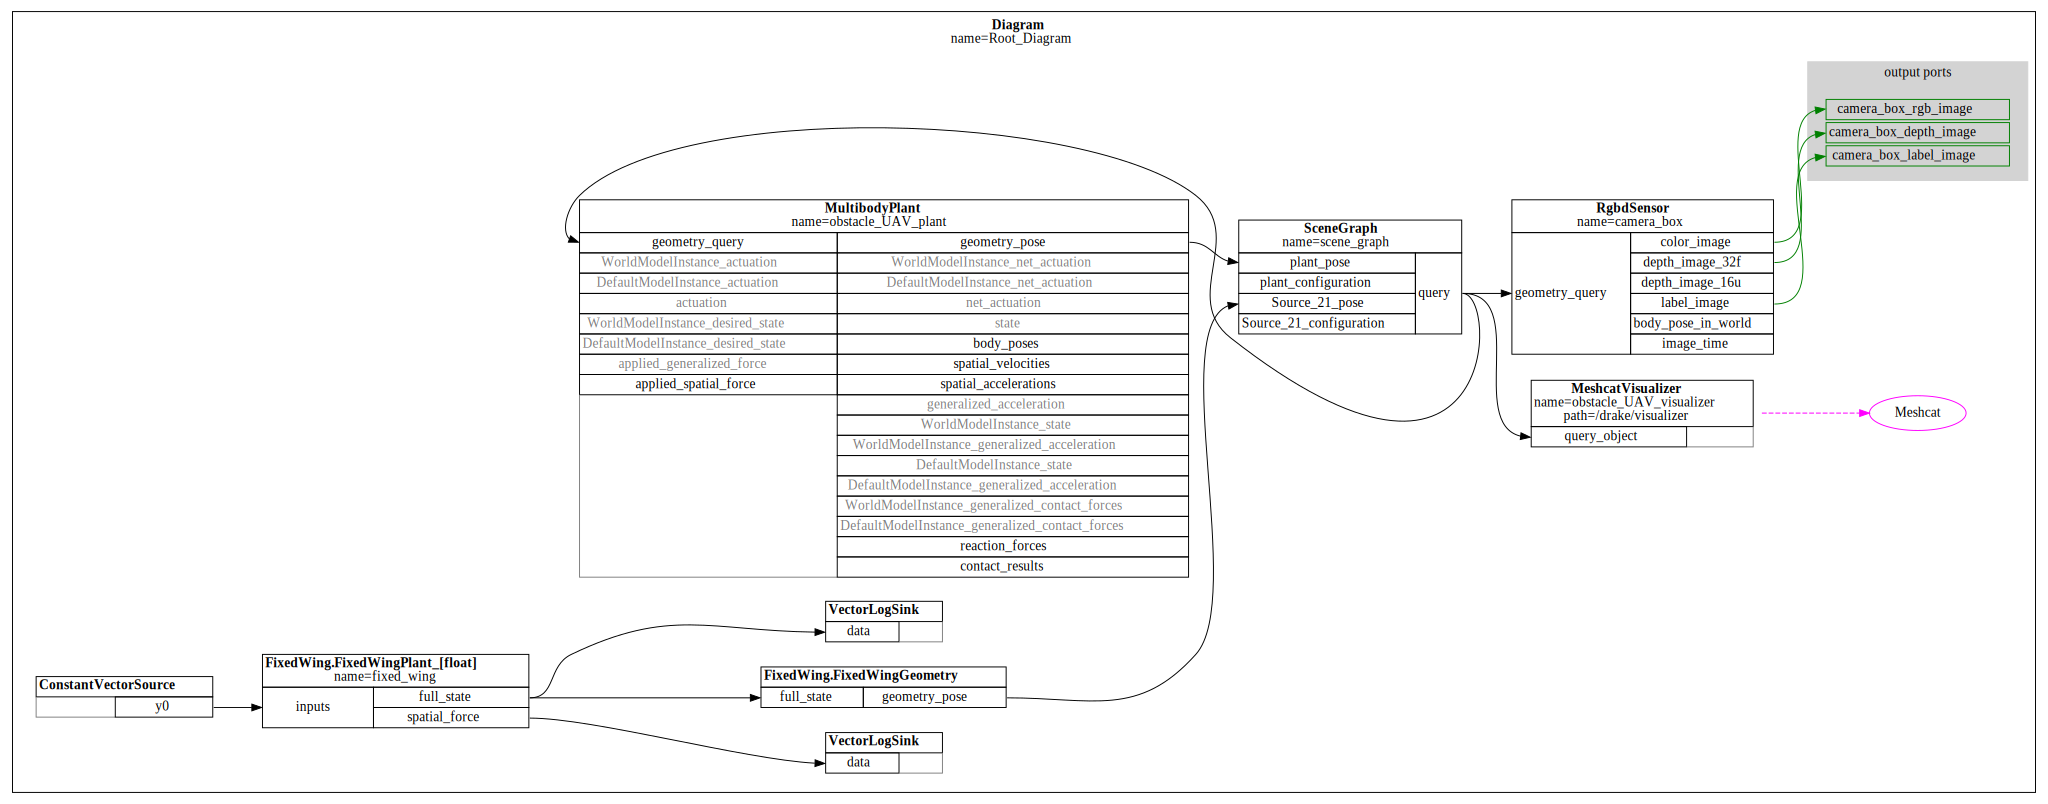

RuntimeError: Disagreement in expected number of frames (6) and the given number of frames (5).

In [9]:

# meshcat = StartMeshcat()

# x = np.zeros(16)
# fw = fw.draw_glider(x, meshcat)


simEnv = sim.SimulationEnvironment()

simEnv.connect_meshcat()
simEnv.add_fixed_wing()


input = np.array([-0.1 ,-0.1, 5, 5])
simEnv.add_constant_inputSource(input)
# simEnv.add_controller(x_traj, u_traj, Q, R, Qf)



simEnv.build_model()
simEnv.save_and_display_diagram(save=False)


meshcat = simEnv.meshcat
diagram = simEnv.diagram

plane_plant = simEnv.fixed_plane
meshcat_visualizer = simEnv.visualizer

# Visualize


In [ ]:

def visualize_frame(name, X_WF, length=0.15, radius=0.003):
    """
    visualize imaginary frame that are not attached to existing bodies

    Input:
        name: the name of the frame (str)
        X_WF: a RigidTransform from frame F to world.

    Frames whose names already exist will be overwritten by the new frame
    """
    AddMeshcatTriad(
        meshcat, "traj_source/" + name, length=length, radius=radius, X_PT=X_WF
    )

    # print("Visualized frame: ", X_WF)

## Visualization of key frames:
def visualize_key_frames(frame_poses):
    for i, pose in enumerate(frame_poses):
        visualize_frame("frame_{}".format(i), pose, length=0.3)
        
        

# Simulator

PLOTTTING #########################################################################33
deltas: 0.5 -0.5 1.0 1.0
delta_el: -0.1 delta_er: -0.1 w_l: 5.0 w_r: 5.0
differential delta : 0.0
Lift moment: 0.0
M_t_b: [0. 0. 0.] 
M_prop: [ 0.         31.66900096  0.        ] 
M_p_b: [0. 0. 0.] 
tau_ab: [0.        0.3407711 0.       ] 
M_elevon_lift: [0. 0. 0.]
deltas: -0.1 -0.1 5.0 5.0
delta_el: -0.1 delta_er: -0.1 w_l: 5.0 w_r: 5.0
differential delta : 0.0
Lift moment: 0.0
M_t_b: [0. 0. 0.] 
M_prop: [ 0.         31.66900096  0.        ] 
M_p_b: [0. 0. 0.] 
tau_ab: [0.        0.3407711 0.       ] 
M_elevon_lift: [0. 0. 0.]
X_a: 1444.0393029019438 
Y_a: -5.854434271924847 
Z_a: 95.28507724495321 
L_b: 0.0 
M_b: 32.009772061512734 
N_b: 0.0

x: 0.0 	y: 0.0 	z: -1.5 	v_a: 10.0 
beta: 0.0 		alpha: 0.0 
chi: 0.0 		gamma: 0.0 		mu: -0.39269908169872414 
p: 0.0 		q: 0.0 		r: 0.0 
delta_le: 0.5 		delta_re: -0.5 		delta_lm: 1.0 		delta_rm: 1.0
deltas: -0.1 -0.1 5.0 5.0
delta_el: -0.1 delta_er: -0.1 w_l: 

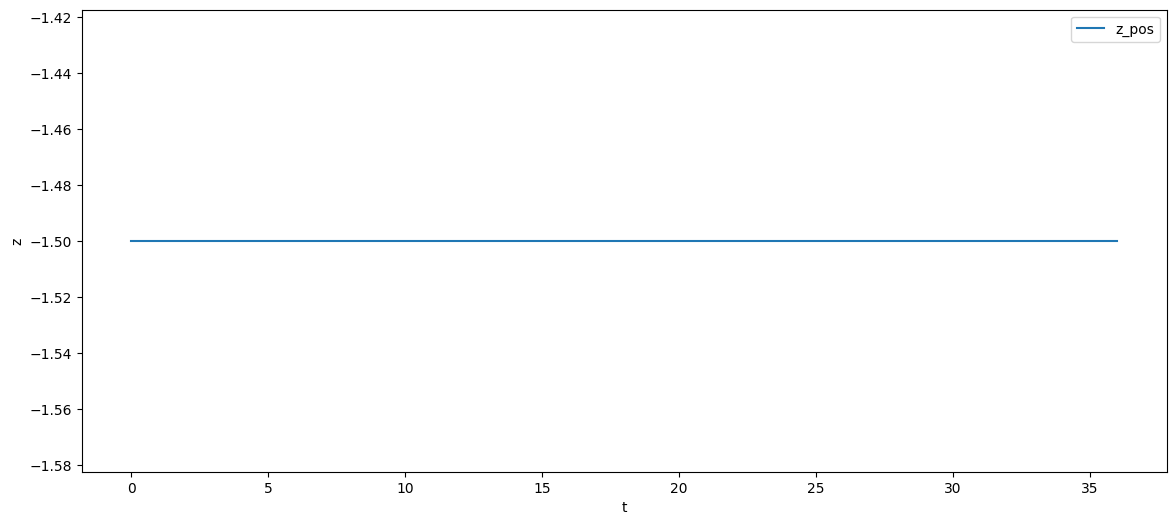

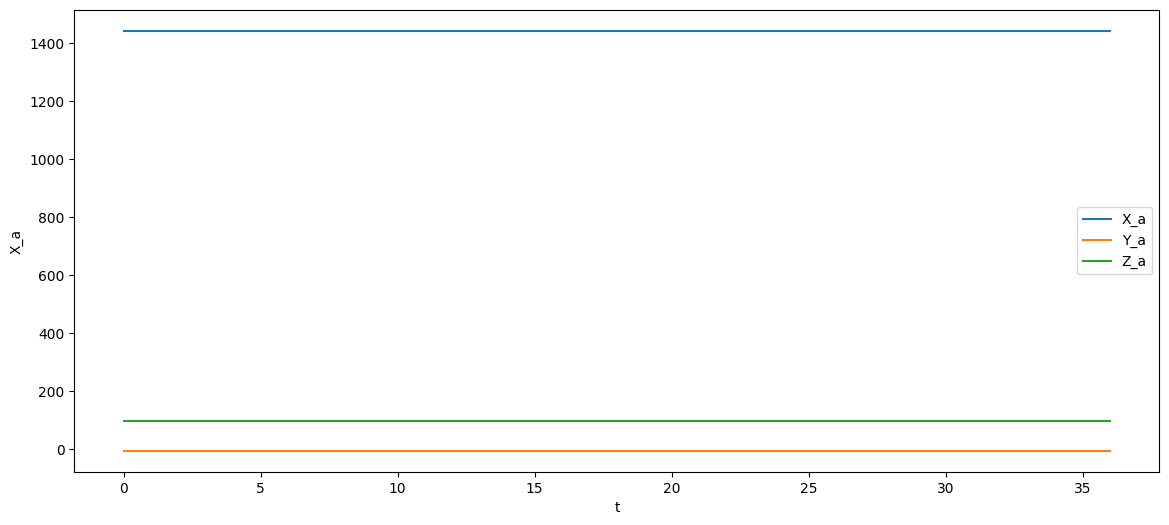

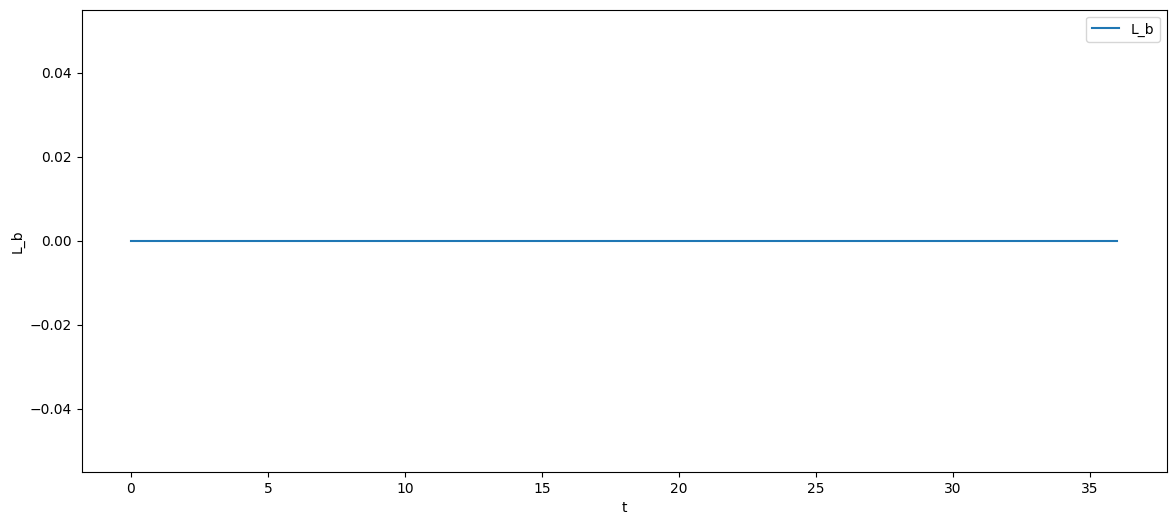

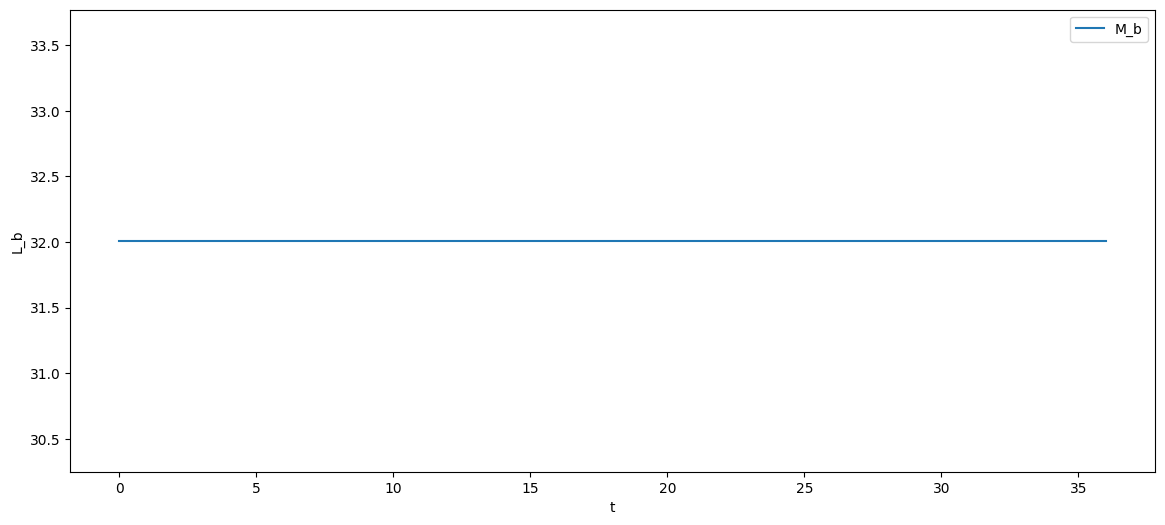

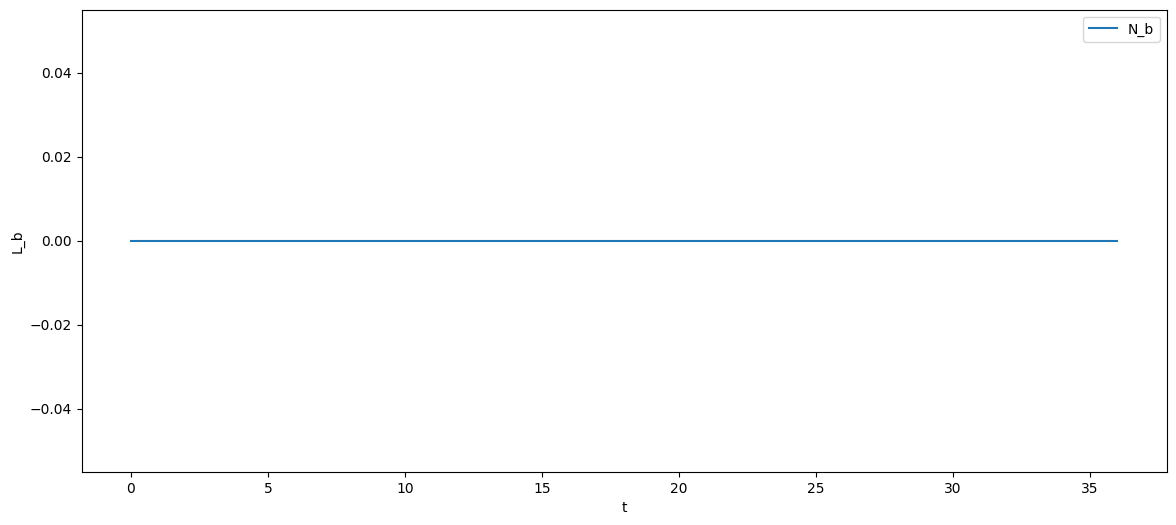

In [ ]:
simulator = Simulator(diagram)
# simulator.set_target_realtime_rate(1.0)

simulator_context = simulator.get_mutable_context()



# fixed_wing_contex = diagram.GetMutableSubsystemContext(plane_plant, simulator_context)
fixed_wing_contex = simEnv.fixed_plane.GetMyMutableContextFromRoot(simulator_context) 


fullState = FullState(np.zeros(16))

fullState.mu = -np.pi/8
fullState.gamma = 0#np.pi/8
fullState.z = -1.5
fullState.x = 0
fullState.y = 0
fullState.v_a = 10

fullState.delta_le = .5
fullState.delta_re = -.5
fullState.delta_rm = 1
fullState.delta_lm = 1


fixed_wing_contex.SetContinuousState(fullState[:])
simulator.Initialize()


meshcat_visualizer.StartRecording()

simulator.AdvanceTo(.5)

meshcat_visualizer.StopRecording()
meshcat_visualizer.PublishRecording()


log_state = simEnv.logger_state.FindLog(simulator_context)
s = FullState(log_state.data())
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(s.z)), s.z, label="z_pos")
# ax.plot(range(len(s.x)), s.x, label="x_pos")
# ax.plot( s.x, s.z, label="simulation")
ax.set_xlabel("t")
ax.set_ylabel("z")
# ax.axis("equal")
ax.legend()

log_force = simEnv.logger_force.FindLog(simulator_context)
F_s = log_force.data()
L_b = F_s[0]
M_b = F_s[1]
N_b = F_s[2]
X_a = F_s[3]
Y_a = F_s[4]
Z_a = F_s[5]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(X_a)), X_a, label="X_a")
ax.plot(range(len(Y_a)), Y_a, label="Y_a")
ax.plot(range(len(Z_a)), Z_a, label="Z_a")
ax.set_xlabel("t")
ax.set_ylabel("X_a")
# ax.axis("equal")
ax.legend()

#plot moments
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(L_b)), L_b, label="L_b")
ax.set_xlabel("t")
ax.set_ylabel("L_b")
# ax.axis("equal")
ax.legend()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(range(len(M_b)), M_b, label="M_b")

ax.set_xlabel("t")
ax.set_ylabel("L_b")
# ax.axis("equal")
ax.legend()


fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(N_b)), N_b, label="N_b")
ax.set_xlabel("t")
ax.set_ylabel("L_b")
# ax.axis("equal")
ax.legend()

PLOTTTING #########################################################################33
deltas: 0.0 -0.0 0.0 0.0
delta_el: -0.1 delta_er: -0.1 w_l: 5.0 w_r: 5.0
differential delta : 0.0
Lift moment: 0.0
M_t_b: [0. 0. 0.] 
M_prop: [ 0.         33.79098657  0.        ] 
M_p_b: [0. 0. 0.] 
tau_ab: [0.         0.00480487 0.        ] 
M_elevon_lift: [0. 0. 0.]
deltas: -0.1 -0.1 5.0 5.0
delta_el: -0.1 delta_er: -0.1 w_l: 5.0 w_r: 5.0
differential delta : 0.0
Lift moment: 0.0
M_t_b: [0. 0. 0.] 
M_prop: [ 0.         33.79098657  0.        ] 
M_p_b: [0. 0. 0.] 
tau_ab: [0.         0.00480487 0.        ] 
M_elevon_lift: [0. 0. 0.]
X_a: 1437.6166498366717 
Y_a: 0.0 
Z_a: 100.08339410339062 
L_b: 0.0 
M_b: 33.79579143922644 
N_b: 0.0

x: 0.0 	y: 1.2246467991473532e-16 	z: -1.0 	v_a: 1.1874342087037917 
beta: 0.0 		alpha: 0.0 
chi: -0.4636476090008061 		gamma: 0.3435808059460913 		mu: 0.0 
p: 0.0 		q: 0.0 		r: 0.0 
delta_le: 0.0 		delta_re: -0.0 		delta_lm: 0.0 		delta_rm: 0.0
deltas: -0.1 -0.1 5.0 5

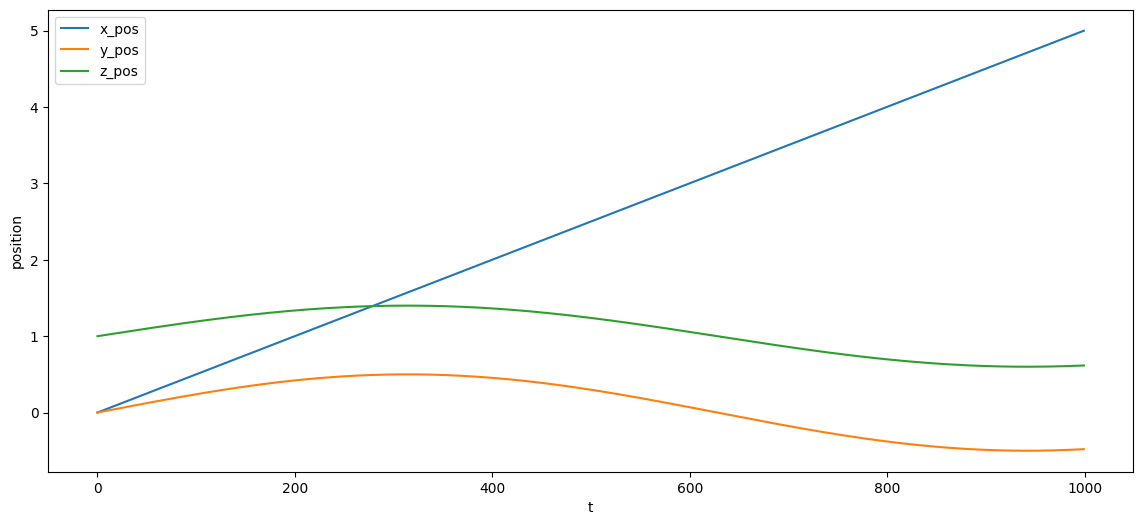

In [ ]:

simulator = Simulator(diagram)
# simulator.set_target_realtime_rate(2.0)
simulator_context = simulator.get_mutable_context()

perching_plane_context = diagram.GetMutableSubsystemContext(plane_plant, simulator_context)

anim = MeshcatAnimation()
fps = anim.frames_per_second()
anim.set_autoplay(True)
meshcat.StartRecording()

# camera = Meshcat.OrthographicCamera()


# meshcat.SetCamera(camera)

meshcat.SetCameraPose([0, 0, 2], [1, 0, 1])
for p, dp, ddp, dddp, t in zip(
    p_numeric,
    dp_numeric,
    ddp_numeric,
    dddp_numeric,
    sample_times_s
):

    fullState = FullState(np.zeros(16))
    stateNED = UnflattenFixedWingStatesNED(p, dp, ddp, dddp, m, g)

    fullState[:12] = stateNED
    
    
    fullState.delta_le = np.clip(fullState.mu*0.7, -0.8, 0.8)
    fullState.delta_re = np.clip(-fullState.mu*0.5, -0.8, 0.8)
    fullState.delta_lm = 1.5*t
    fullState.delta_rm = 1.5*t

    
    
    # fullState.delta_rm = 30*np.pi*t
    # fullState.delta_lm = 30*np.pi*t
    
    X_DrB = ExtractTransformation(stateNED[:])
    R_BF = RollPitchYaw(np.pi/2, np.pi/2, 0).ToRotationMatrix()
    X_BF = RigidTransform(R_BF, [0.1, 0, 0])
    
    
    anim_frame = anim.frame(t)
    
    R_DrB = X_DrB.rotation()
    pos_B = X_DrB.translation()
    
    camera_pos_B = pos_B + R_DrB @ np.array([-1, 0, -.2])
    
    meshcat.SetCameraPose(camera_pos_B, pos_B)
    
    anim.SetTransform(anim_frame, "FPV", X_DrB @ X_BF)
  
    # meshcat.SetTransform("/FPV", X_DrB @ X_BF, t)
    
    
    simulator_context.SetContinuousState(fullState[:])
    simulator.AdvanceTo(t)
    

meshcat.StopRecording()
meshcat.PublishRecording()
# meshcat.SetAnimation(anim)







# plot the state of p_numeric
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(p_numeric)), p_numeric[:, 0], label="x_pos")
ax.plot(range(len(p_numeric)), p_numeric[:, 1], label="y_pos")
ax.plot(range(len(p_numeric)), p_numeric[:, 2], label="z_pos")
ax.set_xlabel("t")
ax.set_ylabel("position")
# ax.axis("equal")
ax.legend()
